### 代理模型的实验

##### 导入包

In [2]:
# import
import os,sys
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
sys.path.append("../models/")
from uncertainty_surrogate_model import UncertaintySurrogateModel
from model_utils import MyDataset,train_val_test_split,resume
from mdn_model import mdn_mean,variance,aleatoric_uncertainty,epistemic_uncertainty

from scipy.stats import norm
from pynverse import inversefunc

##### 实验设置

In [3]:
# configuration
SAMPLE_SIZE = (8,4)
BATCH_SIZE = 16
LOOKBACK = 8
LOOKAHEAD = 4

mpl.rcParams['font.family'] = ['Times New Roman','SimSun'] 
mpl.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
mpl.rcParams['font.size'] = 9  # 按磅数设置的
mpl.rcParams['figure.dpi'] = 300
cm = 1/2.54  # centimeters in inches
mpl.rcParams['figure.figsize'] = (12*cm,8*cm)
mpl.rcParams['savefig.dpi'] = 900
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.facecolor'] = 'white'

In [4]:
# directory
surrogate_dir = "../results/experiment/surrogate/"  # 结果保存目录
dataset_dir = "../results/experiment/dataset/"  # 数据读取目录
data_dir = "../data/training_data/standard/"  # 数据读取目录
model_dir = ""

model_config = {'model_dir': model_dir,
                'batch_size': 1,
                'lookback': 8,
                'lookahead': 4,
                'device': 'cpu',
                'train_predict_mode': 'recursive',
                'sample_size': (8,4),
                'seed': 0,
                'num_components': 48}

dl_config = {'seed': 0,
             'data_dir': data_dir,
             'batch_size': 32,
             'lookback': 8,
             'lookahead': 4,
             'sample_size': (8,4),
             'num_workers': 2}

##### 数据集准备

In [5]:
# 导入延误数据
y = np.load(dataset_dir+'train_delay_data.npy')  # (num_samples,lookahead)

In [6]:
# 读取预测结果
y_pred = np.load(surrogate_dir+'train_uncertainty_pred.npy')
y_res = np.load(surrogate_dir+'train_uncertainty_output.npz')  # dict
c_pred,mu_pred,sigma_pred = tuple(y_res.values())

# c_pred: (num_samples,lookahead,num_components,1)
# mu_pred: (num_samples,lookahead,num_components,1)
# sigma_pred: (num_samples,lookahead,num_components,1)

##### 预测结果定性分析

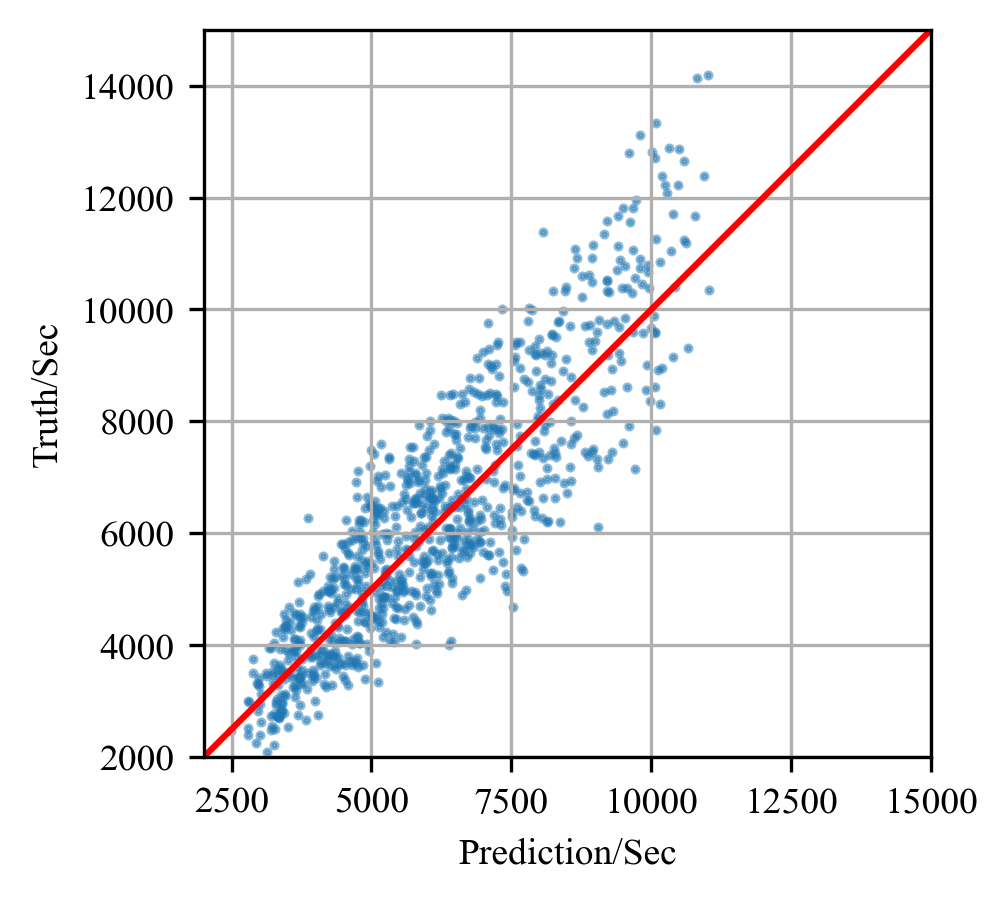

In [64]:
# 预测值与真实值关系
fig,ax = plt.subplots()
lookahead = 0
ax.scatter(y_pred[:,lookahead],y[:,lookahead],s=2.0,alpha=0.5)
    
plt.plot([2000,15000],[2000,15000],c='r',label='y=x')
ax.set_xlabel("Prediction/Sec")
ax.set_ylabel("Truth/Sec")
ax.set_xlim([2000,15000])
ax.set_ylim([2000,15000])
ax.set_aspect("equal")
# plt.legend()
fig.savefig(surrogate_dir+'truth-prediction-scatter-test.jpg',bbox_inches='tight')

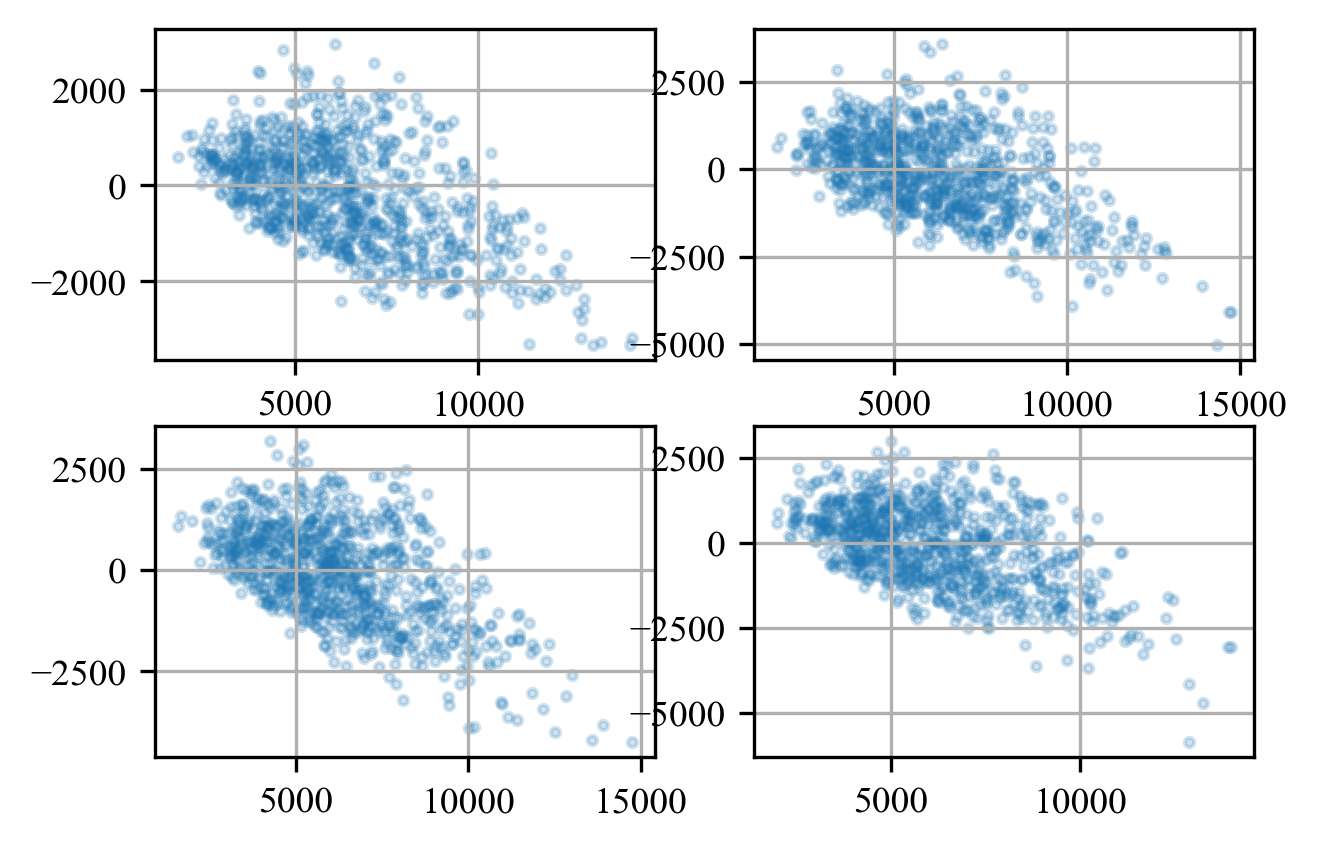

In [8]:
# 误差-真实值
fig,axs = plt.subplots(2,2)
for i in range(model_config['lookahead']):
    axs[i//2,i%2].scatter(y[:,i],y_pred[:,i]-y[:,i],s=5.0,alpha=0.2,label=f'{i+1}-step-ahead')

ax.set_xlabel("Truth")
ax.set_ylabel("Prediction Error")
ax.legend()

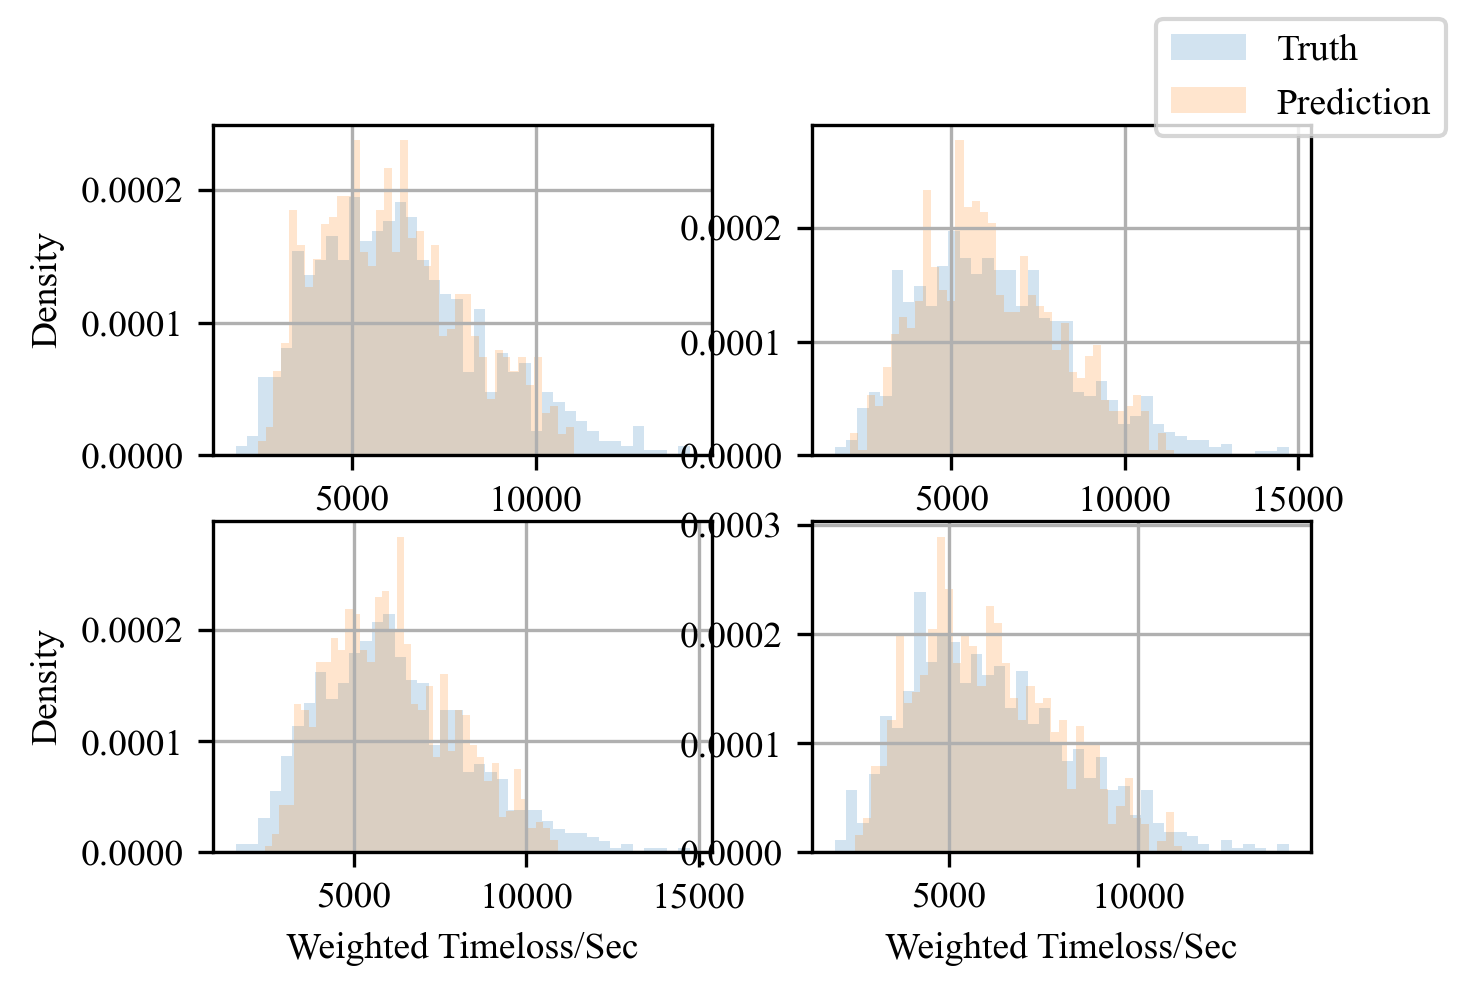

In [9]:
# 真实值与预测值分布
fig,axs = plt.subplots(2,2)
for i in range(model_config['lookahead']):
    p1 = axs[i//2,i%2].hist(y[:,i],alpha=0.2,bins=40,density=True,label=f'{i+1}-step-ahead truth')
    p2 = axs[i//2,i%2].hist(y_pred[:,i],alpha=0.2,bins=40,density=True,label=f'{i+1}-step-ahead prediction')

axs[1,0].set_xlabel("Weighted Timeloss/Sec")
axs[1,1].set_xlabel("Weighted Timeloss/Sec")
axs[0,0].set_ylabel("Density")
axs[1,0].set_ylabel("Density")
fig.legend({'Truth':p1,'Prediction':p2})

##### 预测结果定量分析

In [45]:
# MAPE
def get_mape(y_pred,y):
    mape = (np.abs(y_pred-y)/y).mean(0)  # for each kind of metric, it's (lookahead)
    return mape

mape = get_mape(y_pred,y)
print(mape)

[0.1516396  0.16190164 0.16084834 0.17047431]


In [11]:
# RMSE
def get_rmse(y_pred,y):
    rmse = np.sqrt(((y_pred-y)**2).mean(0))  # for each kind of metric, it's (lookahead)
    return rmse

rmse = get_rmse(y_pred,y)
print(rmse)

[1099.74001473 1229.45298183 1223.48314808 1213.44281361]


##### 不确定性建模分析

In [53]:
# 计算不确定性
# (c_pred,mu_pred,sigma_pred)
au = aleatoric_uncertainty((c_pred,mu_pred,sigma_pred)).squeeze(-1)
eu = epistemic_uncertainty((c_pred,mu_pred,sigma_pred)).squeeze(-1)
var = variance((c_pred,mu_pred,sigma_pred)).squeeze(-1)

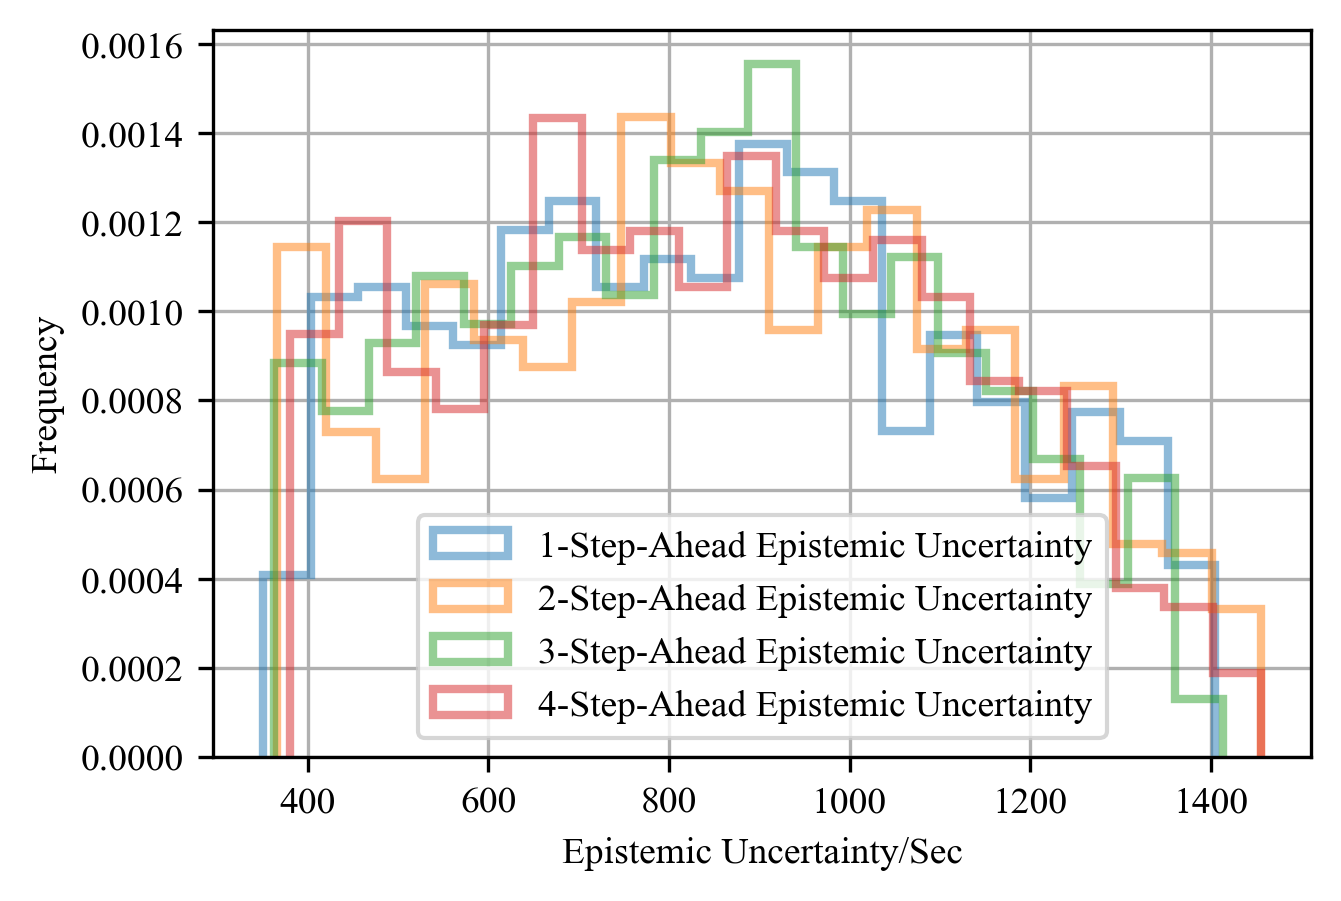

In [22]:
# 模型不确定性分布
fig,ax = plt.subplots()
for i in range(model_config['lookahead']):
    ax.hist(np.sqrt(eu[:,i]),alpha=0.5,bins=20,label=f'{i+1}-Step-Ahead Epistemic Uncertainty',
            histtype='step',linewidth=2.0,cumulative=False,density=True)
    
ax.set_xlabel("Epistemic Uncertainty/Sec")
ax.set_ylabel("Frequency")
ax.legend()

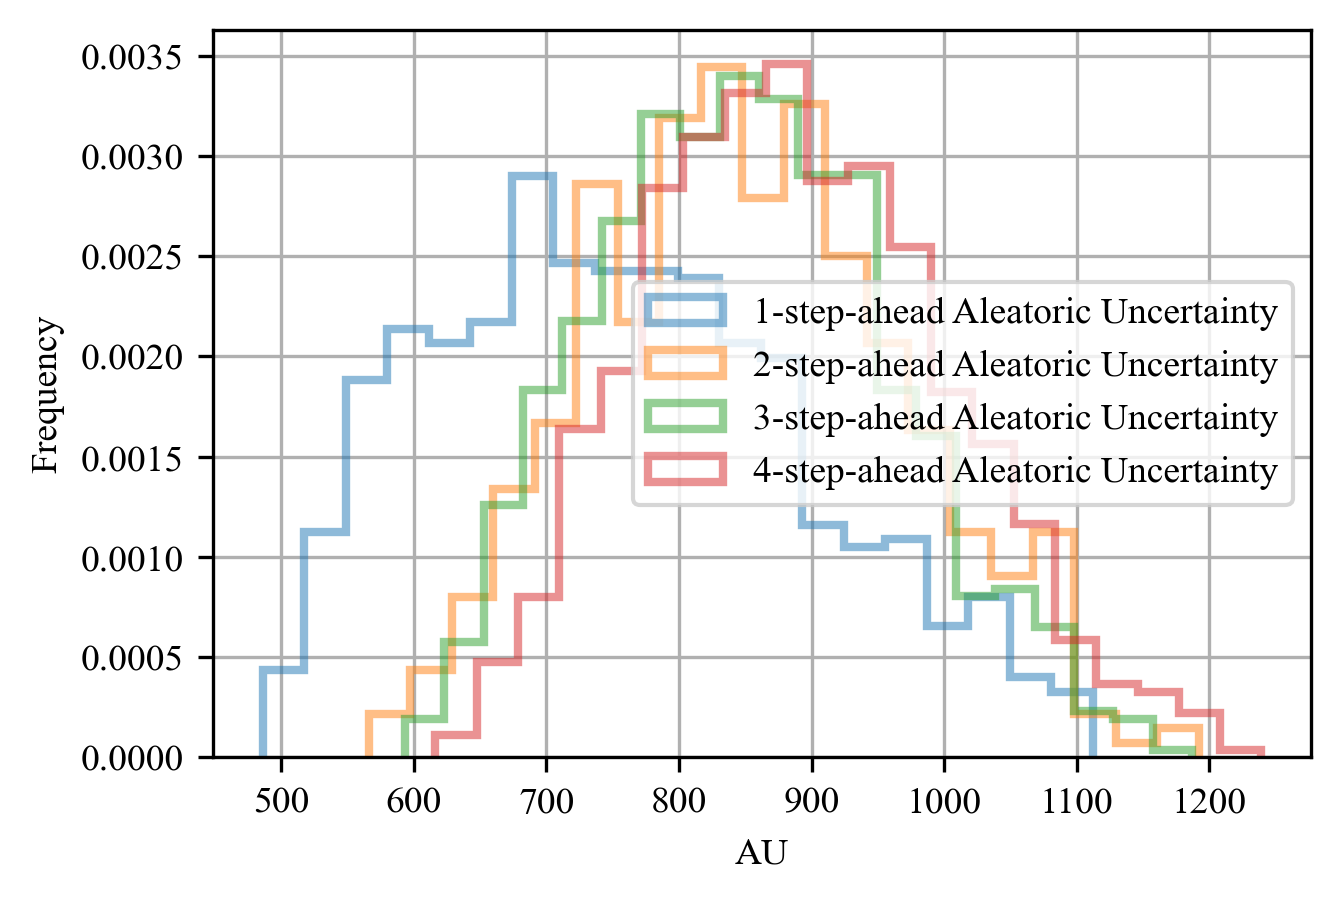

In [14]:
# 数据不确定性分布
fig,ax = plt.subplots()
for i in range(model_config['lookahead']):
    ax.hist(np.sqrt(au[:,i]),alpha=0.5,bins=20,label=f'{i+1}-step-ahead Aleatoric Uncertainty',
            histtype='step',linewidth=2.0,cumulative=False,density=True)
    
ax.set_xlabel("AU")
ax.set_ylabel("Frequency")
ax.legend()

In [7]:
# Calibration Curve: Process 
x = np.linspace(0.02,0.48,10)
n_p = len(x)
n_s = c_pred.shape[0]
n_c = c_pred.shape[2]

# qp = np.zeros((n_s,n_p))
ub = np.zeros((4,n_s,n_p))
lb = np.zeros((4,n_s,n_p))
xx = np.zeros((4,n_p))
pbar = tqdm(total=n_s,desc="Processing:")
for step in range(4):
    for i in range(n_s):
        cdf = lambda x: (c_pred[i,step]*norm(loc=mu_pred[i,step],scale=sigma_pred[i,step]).cdf(np.expand_dims(x,0))).sum(0)
        ub[step,i,:] = inversefunc(cdf,0.5+x,domain=[500.0,20000.0])
        lb[step,i,:] = inversefunc(cdf,0.5-x,domain=[500.0,20000.0])
        # qp[i,:] = inversefunc(cdf,x,domain=[1000.0,20000.0])
        pbar.update(1)

    for i in range(n_p):
        xx[step,i] = ((y[:,step]<=ub[step,:,i]) & (y[:,step]>=lb[step,:,i])).sum()

    xx[step] = xx[step]/c_pred.shape[0]

# 处理需要挺长时间，保存下来
np.savez(surrogate_dir+'reliability-diagram-step-ahead.npz',x=x,xx=xx)

Processing:: 100%|██████████| 882/882 [1:01:20<00:00,  4.17s/it]


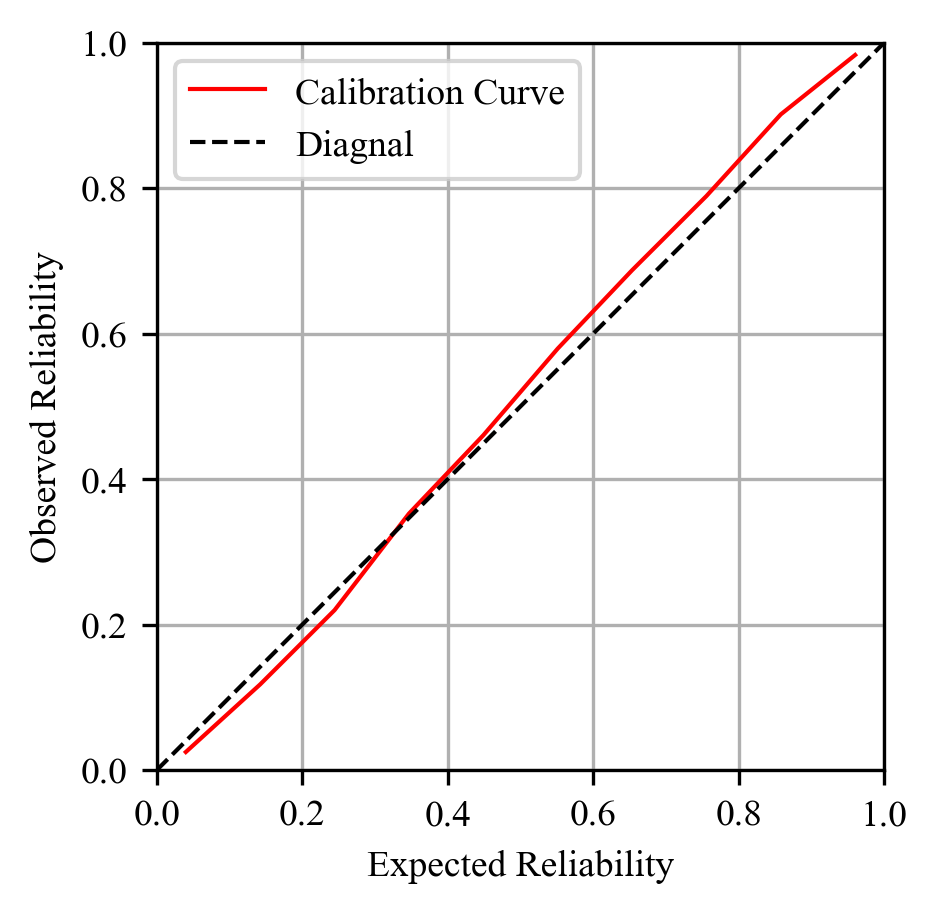

In [18]:
# Calibration Curve: Plot
x,xx = tuple(np.load(surrogate_dir+'reliability-diagram-test.npz').values())
fig,ax = plt.subplots()
ax.plot(2*x,xx,'r',label="Calibration Curve",linewidth=01.0)
ax.plot(np.linspace(0,1,20),np.linspace(0,1,20),'k--',label='Diagnal',linewidth=1.0)
ax.set_xlabel('Expected Reliability')
ax.set_ylabel('Observed Reliability')
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()
fig.savefig(surrogate_dir+'reliability-diagram-test.jpg',bbox_inches='tight')

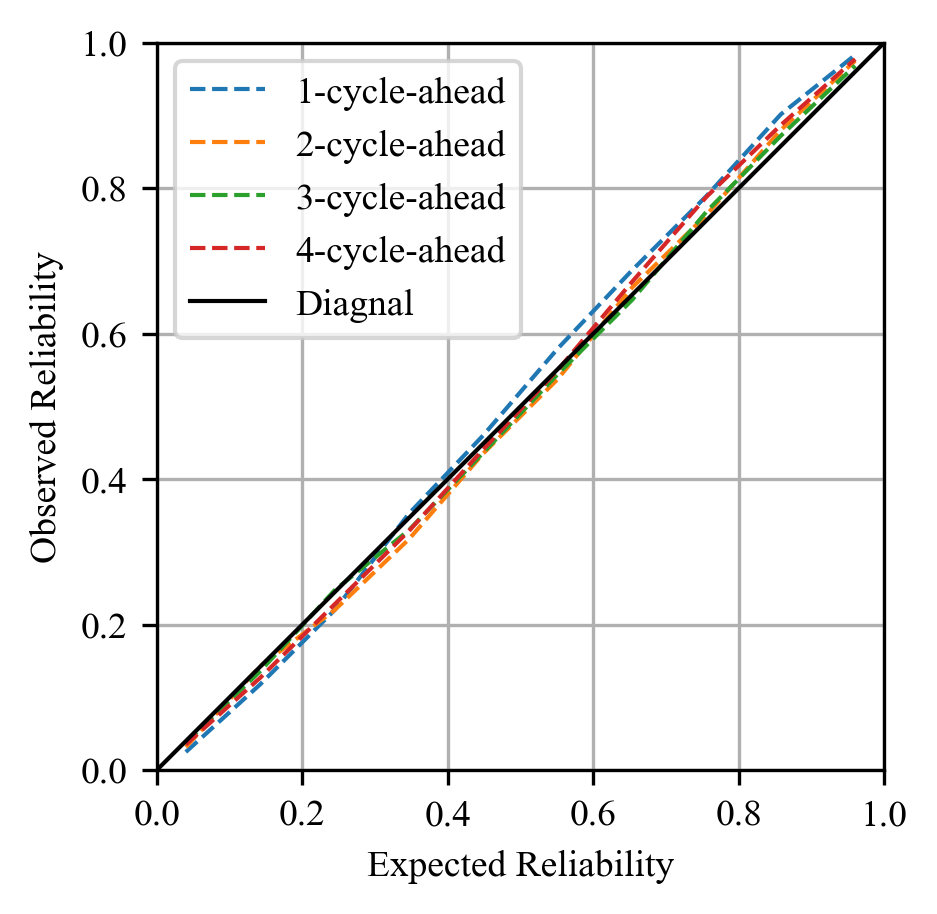

In [67]:
# Calibration Curve: Plot
x,xx = tuple(np.load(surrogate_dir+'reliability-diagram-step-ahead.npz').values())
fig,ax = plt.subplots()
for step in range(4):
    ax.plot(2*x,xx[step],'--',label=f"{step+1}-cycle-ahead",linewidth=1.0)
ax.plot(np.linspace(0,1,20),np.linspace(0,1,20),'k-',label='Diagnal',linewidth=1.0)
ax.set_xlabel('Expected Reliability')
ax.set_ylabel('Observed Reliability')
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()
fig.savefig(surrogate_dir+'reliability-diagram-step-ahead.jpg',bbox_inches='tight')

##### 不确定性与误差

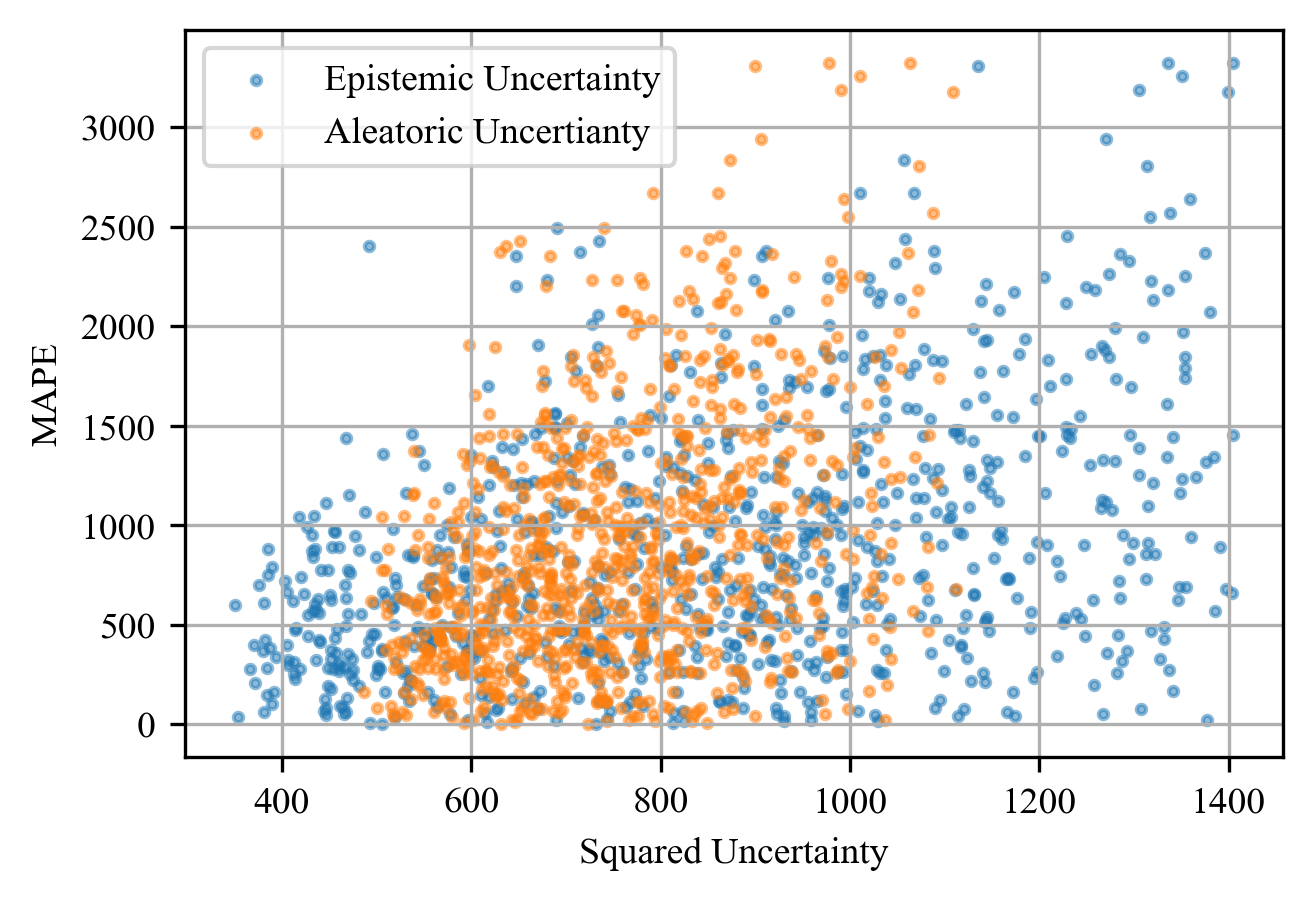

In [27]:
# 不确定性和MAPE的相关性
fig,ax = plt.subplots()
ax.scatter(np.sqrt(eu[:,0]),np.abs(y_pred[:,0]-y[:,0]),s=5.0,alpha=0.5,label='Epistemic Uncertainty')
ax.scatter(np.sqrt(au[:,0]),np.abs(y_pred[:,0]-y[:,0]),s=5.0,alpha=0.5,label='Aleatoric Uncertianty')
ax.legend()
ax.set_xlabel("Squared Uncertainty")
ax.set_ylabel("MAPE")
fig.savefig(surrogate_dir+'error-uncertainty-test.jpg',bbox_inches='tight')

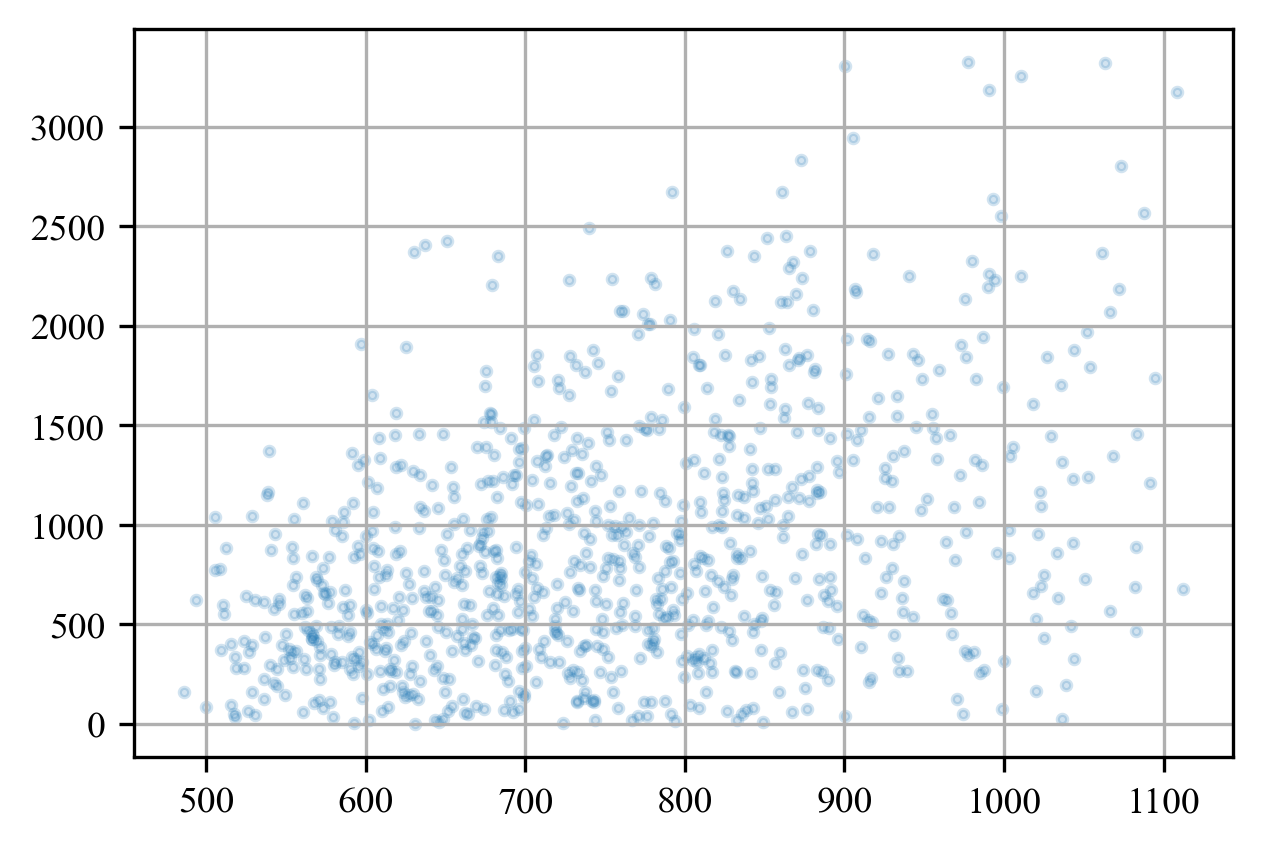

In [60]:
# 预测变异系数和MAPE
fig,ax = plt.subplots()
ax.scatter(np.sqrt(au[:,0]),np.abs(y_pred[:,0]-y[:,0]),s=5.0,alpha=0.2)

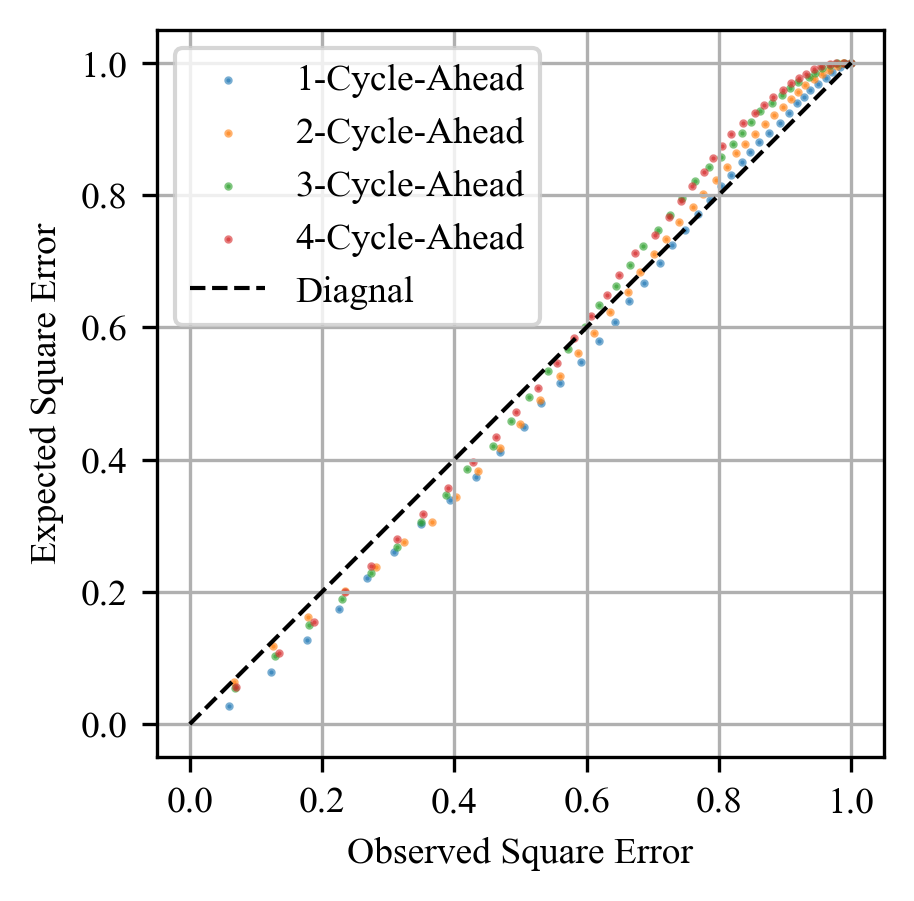

In [66]:
# 不确定性对预测误差的刻画
fig,ax = plt.subplots()
for step in range(4):
    num = au.shape[0]
    expected_bins,bin_edges = np.histogram(eu[:,step],bins=41,density=False)
    expected_bins = expected_bins.cumsum()/expected_bins.sum()
    observed_bins = np.histogram((y_pred[:,step]-y[:,step])**2,bins=bin_edges,density=False)[0]
    observed_bins = observed_bins.cumsum()/observed_bins.sum()

    # param = np.polyfit(observed_bins,expected_bins,2)
    # fitted_bins = param[0]*(np.sort(observed_bins))**2 + param[1]*(np.sort(observed_bins))**1 + param[2]

    ax.scatter(observed_bins,expected_bins,s=1.0,alpha=0.6,label=f'{step+1}-Cycle-Ahead')
    # ax.plot(expected_bins,fitted_bins,'r',label=f'Regression Curve: {param[0]}x^2+{param[1]}x+{param[2]}')
    # ax.plot(np.sort(observed_bins),fitted_bins)

ax.plot(np.linspace(0,1,2),np.linspace(0,1,2),'k--',label='Diagnal',linewidth=1.0)
# ticks = np.arange(0,1,0.1)
# lim = [0,0.1]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
ax.set_xlabel('Expected Quantile for Square Error')
ax.set_ylabel('Expected Square Error')
ax.set_aspect('equal')
ax.legend()
fig.savefig(surrogate_dir+f'square-error-diagram-eu-train.jpg',bbox_inches='tight')